# Forecasting the Commute: Modelling Weather Effects on Wellington Traffic
### Rachel Anastasi-Marais
#### Capstone Project, November 2025

*   This Notebook contains OneHot Encoding, Feature Selection, and Machine Learning models


**Target feature:** traffic_count (continuous)
**Predictors features:**
* weather features taken from the previous hour;
* time of day ("AM" vs "PM" hours relevant to traffic commute times). Commute windows are 6am to 9am and 4pm to 7pm;
* hour_of_peak (the first "1", second "2", or third "3" hour of each commute window - *OneHot encoded*;
* zones (where traffic counts were taken, i.e. North, South, East, West, Central Wellington) - *OneHot encoded*;
* wind direction - *OneHot encoded* compass directions

**Rows:** 14,160

**Goal:** Predict commuting traffic counts from weather and contextual features


In [ ]:
# pip installs
#!apt-get install -y openjdk-11-jdk-headless
#!pip install pyspark

In [ ]:
# import libraries

# Core modeling
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor

# Pipeline & preprocessing
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

# Model evaluation
from sklearn.model_selection import train_test_split, TimeSeriesSplit, cross_val_score, KFold, RandomizedSearchCV

from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingRandomSearchCV

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Feature selection
from sklearn.inspection import permutation_importance

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Import cleaned traffic count and weather data

In [ ]:
# Import cleaned data

df = pd.read_csv(r"/content/drive/MyDrive/Colab Notebooks/data_cleaning_output_3.csv/weather_traffic_final_v3.csv"
)

# Show inferred dtypes (similar to printSchema in Spark)
print(df.dtypes)

# Show first 5 rows (similar to df.show(5, truncate=False))
print(df.head(5))

zone                   object
traffic_count           int64
temp_prev             float64
sunshine_prev         float64
rain_prev             float64
windspeed_prev        float64
gusts_prev            float64
wind_direction         object
weathercode_global    float64
hour_of_peak            int64
time_binary             int64
move_centrally          int64
is_spring               int64
is_summer               int64
is_autumn               int64
is_winter               int64
dtype: object
    zone  traffic_count  temp_prev  sunshine_prev  rain_prev  windspeed_prev  \
0  north            156       10.0         0.0000        0.0            21.7   
1  north             53       10.8        48.8155        0.0             9.3   
2  south            420       16.8        60.0000        0.0            12.7   
3  south            110       19.1        60.0000        0.0            11.2   
4   west              7        7.5         0.0000        0.0             6.5   

   gusts_prev wind_direct

In [ ]:
# Rows and Columns
df.shape

(14160, 16)

In [ ]:
df["zone"].value_counts()

,count
zone,
east,4080
south,3660
central,3000
west,2280
north,1140


### OneHot Encoding for zone and wind_direction

#### 1. Normalise "zone" groups, then one hot encode

In [ ]:
## Set customer transformer for frequency normalisation on "zone" feature
class FrequencyNormalizer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        self.means_ = X.mean(axis=0)
        return self
    def transform(self, X):
        return X / self.means_

#### Define X and y variables

In [ ]:
X = df.drop(columns=["traffic_count"])
y = df["traffic_count"]

# Random Train/test split (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


### Visualise the relationship between weathercode_global and wind_direction using training data set

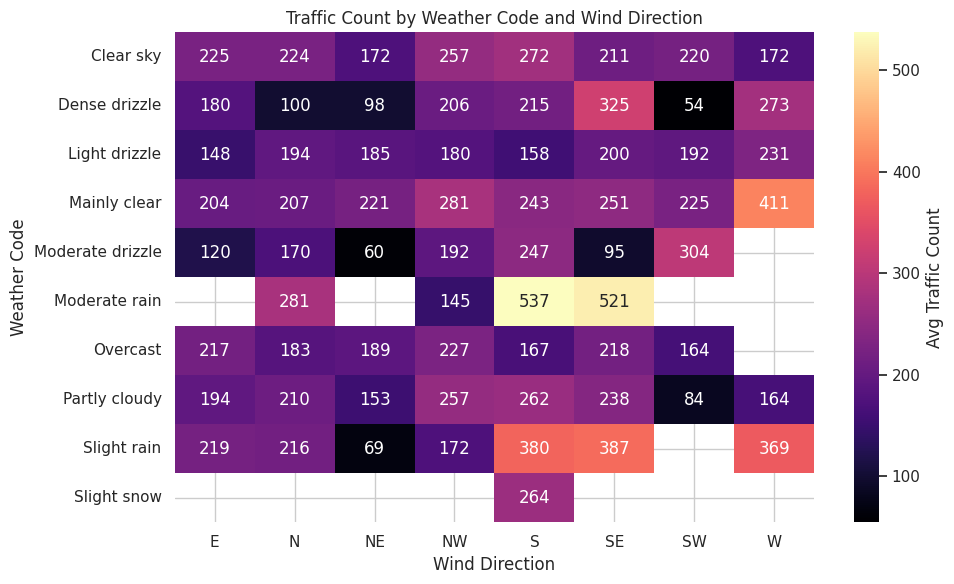

In [ ]:
## Heatmap of X_train weathercode vs winddirection coloured by y_train (traffic_count)

# re-encode text weather labels
wmo_map = {
    0: "Clear sky",
    1: "Mainly clear",
    2: "Partly cloudy",
    3: "Overcast",
    51: "Light drizzle",
    53: "Moderate drizzle",
    55: "Dense drizzle",
    61: "Slight rain",
    63: "Moderate rain",
    71: "Slight snow"
}


# Combine predictors and target into one DataFrame
df = X_train.copy()
df['traffic_count'] = y_train

# Convert scaled values to nearest WMO code
df["weathercode_wmo"] = (df["weathercode_global"] * 99).round().astype(int)
df["weathercode_label"] = df["weathercode_wmo"].map(wmo_map)

# Pivot table: average traffic_count by weathercode_label and wind_direction
pivot_table = df.pivot_table(
    index='weathercode_label',
    columns='wind_direction',
    values='traffic_count',
    aggfunc='mean'
)

# Plot heatmap
plt.figure(figsize=(10, 6))
#sns.set(style='whitegrid')

# Choose a palette other than YlGnBu or PuBuGn
sns.heatmap(
    pivot_table,
    annot=True, fmt=".0f", # Changed to .0f for whole numbers
    cmap='magma',        # try 'coolwarm', 'viridis', or 'magma'
    cbar_kws={'label': 'Avg Traffic Count'},
    linewidths=0 # Remove grid lines
)

plt.title('Traffic Count by Weather Code and Wind Direction')
plt.xlabel('Wind Direction')
plt.ylabel('Weather Code')
plt.tight_layout()
plt.savefig("heatmap_previousweather_winddir_Xtrain.png", dpi=250, bbox_inches="tight")
plt.show()

**Heatmap of average traffic count vs previous hour's weather code and wind direction, observations:**
The training set maintains the same pattern of average higher traffic counts when there has been slight rain with a South-Westerly wind, or moderate rain with a Southerly wind.

In [ ]:
## Selective preprocessing for binary, categorical, and numeric features

numeric_features = ["gusts_prev", "rain_prev", "sunshine_prev", "temp_prev", "windspeed_prev", "weathercode_global"]
binary_features =  ["time_binary", "move_centrally", "is_spring", "is_summer", "is_winter"]
                    # implicitly dropping "is_autumn" essentially dummy-encodes the season feature group]

categorical_features = ["wind_direction", "hour_of_peak"]
zone_feature = ["zone"]

# Transformers
numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(drop="first", sparse_output=False)
zone_transformer = Pipeline(steps=[
    ("onehot", OneHotEncoder(drop="first", sparse_output=False)),
    ("freqnorm", FrequencyNormalizer())
])

# ColumnTransformer
preprocessor = ColumnTransformer(transformers=[
    ("num", numeric_transformer, numeric_features),
    ("bin", "passthrough", binary_features),
    ("cat", categorical_transformer, categorical_features),
    ("zone", zone_transformer, zone_feature)
])

## Model 1: Ridge Regression

In [ ]:
## Ridge regression pipeline and Fit
ridge_pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("regressor", Ridge(alpha=1.0, random_state=42))
])

ridge_pipeline.fit(X_train, y_train)

# Predictions
y_pred = ridge_pipeline.predict(X_test)

# Metrics
rmse_rr = mean_squared_error(y_test, y_pred) ** 0.5
mae_rr = mean_absolute_error(y_test, y_pred)
r2_rr = r2_score(y_test, y_pred)

print(f"Ridge Regression")
print(f"RMSE: {rmse_rr:.3f}")
print(f"MAE: {mae_rr:.3f}")
print(f"R²: {r2_rr:.3f}")

Ridge Regression
RMSE: 192.806
MAE: 143.254
R²: 0.141


**Interpreting results:**
* RMSE ~193.2 and MAE ~ 143.3 indicate predictions made by this baseline model are off by ~140-190 vehicles.
* R2 = 0.138: this model only explains about 14% of the variance in traffic counts.
* Overall this model performed poorly in predicting traffic counts from weather and contextual data.

Having set the baseline, we will first visualise these results, then look to improve them.

### Plot Ridge Regression results

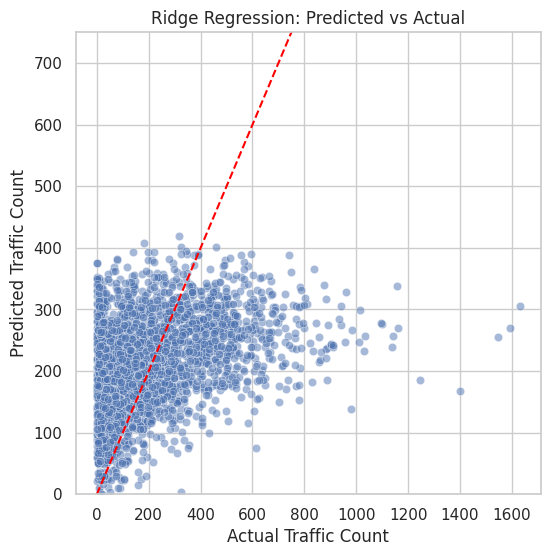

In [ ]:
## Predicted vs actual

plt.figure(figsize=(6,6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()],
         color="red", linestyle="--")
plt.xlabel("Actual Traffic Count")
plt.ylabel("Predicted Traffic Count")
plt.title("Ridge Regression: Predicted vs Actual")

# Limit y-axis to 0–750
plt.ylim(0, 750)
plt.savefig("Model1_ridge_regression_scatter.png", dpi=250, bbox_inches="tight")
plt.show()

**Predicted vs actual plot, observations:** This plot demonstrates the **underfitting** we can infer from the `low R² Score`, i.e. that the model only expains about 13.8% of the variance in the traffic counts. The spread of plotted points away from the red line indicates the low accuracy of this model, and leaves 86.2% of the variance unexplained: the model is generally not accurately predicting traffic count.

### Plot Ridge Regression Coefficients - visualise feature importance

/tmp/ipython-input-931044144.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Coefficient", y="Feature", data=coef_df, palette="viridis")


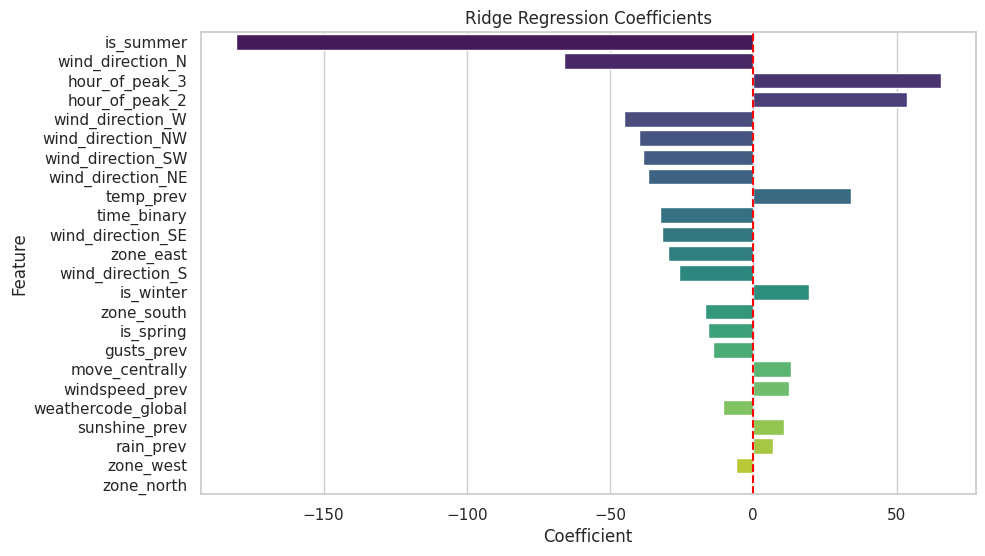

In [ ]:
## Coefficient Plot

# Extract feature names
feature_names = (
    numeric_features +
    binary_features +
    list(ridge_pipeline.named_steps["preprocessor"].named_transformers_["cat"]
         .get_feature_names_out(categorical_features)) +
    list(ridge_pipeline.named_steps["preprocessor"].named_transformers_["zone"]
         .named_steps["onehot"].get_feature_names_out(zone_feature))
)

coefficients = ridge_pipeline.named_steps["regressor"].coef_

coef_df = pd.DataFrame({
    "Feature": feature_names,
    "Coefficient": coefficients
}).sort_values(by="Coefficient", key=abs, ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(x="Coefficient", y="Feature", data=coef_df, palette="viridis")
plt.axvline(0, color="red", linestyle="--")
plt.title("Ridge Regression Coefficients")
plt.savefig("Model1_ridge_regression_coefficients.png", dpi=250, bbox_inches="tight")
plt.show()

**Coefficient Plot, observations:**
*This plot shows the size of the effect that the model attributes to each feature after scaling*

* hour of peak "positions" relate to the relative placement of each hour of a 3-hour commuter window - the latter positions (7am & 8am and 5pm & 6pm) have a greater effect traffic count than the 1st hour of the morning or evening commute;

* temp_prev: the weather in the previous hour contributes to a drivers' choice to commute by road;


This model attributes the `least` effects to these features, implying that the other features from the same group have significant effects:

* seasonality matters - traffic counts are lower in the warmer months, implying higher traffic in the colder months;

* wind direction matters: wind from the north has a strong negative effect on predicting traffic - northern winds tend to be warmer, implying there is more traffic when the wind is colder.


In [ ]:
# Get the categories from the one-hot encoder for wind_direction
wind_direction_categories = preprocessor.named_transformers_['cat'].categories_
print("Wind direction categories in the order they were processed:")
print(wind_direction_categories[0])

# Get the feature names generated by the one-hot encoder
cat_feature_names = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features)
print("\nOne-hot encoded feature names:")
print(cat_feature_names)

Wind direction categories in the order they were processed:
['E' 'N' 'NE' 'NW' 'S' 'SE' 'SW' 'W']

One-hot encoded feature names:
['wind_direction_N' 'wind_direction_NE' 'wind_direction_NW'
 'wind_direction_S' 'wind_direction_SE' 'wind_direction_SW'
 'wind_direction_W' 'hour_of_peak_2' 'hour_of_peak_3']


## Model 2: Lasso Regression

### Lasso Regression Pipeline and Fit

In [ ]:
lasso_pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("regressor", Lasso(alpha=1.0, random_state=42))
])

lasso_pipeline.fit(X_train, y_train)
y_pred_lasso = lasso_pipeline.predict(X_test)

rmse_lr = mean_squared_error(y_test, y_pred_lasso) ** 0.5
mae_lr = mean_absolute_error(y_test, y_pred_lasso)
r2_lr = r2_score(y_test, y_pred_lasso)

print(f"Lasso Regression")
print(f"RMSE: {rmse_lr:.3f}")
print(f"MAE: {mae_lr:.3f}")
print(f"R²: {r2_lr:.3f}")

Lasso Regression
RMSE: 192.864
MAE: 143.277
R²: 0.140


### Plot Lasso Regression Predicted vs Actual Traffic Counts

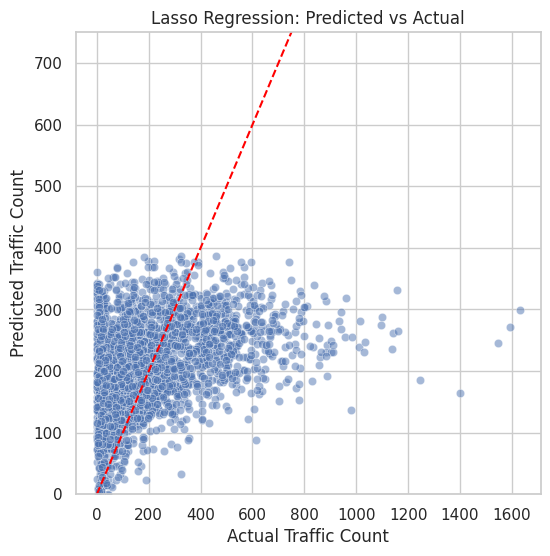

In [ ]:
## Plot Lasso Regression Predicted vs Actual

plt.figure(figsize=(6,6))
sns.scatterplot(x=y_test, y=y_pred_lasso, alpha=0.5)
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()],
         color="red", linestyle="--")
plt.xlabel("Actual Traffic Count")
plt.ylabel("Predicted Traffic Count")
plt.title("Lasso Regression: Predicted vs Actual")
plt.ylim(0, 750)
plt.savefig("Model2_lasso_regression_scatter.png", dpi=250, bbox_inches="tight")
plt.show()

**Plot Lasso Regression Actual vs Predicted Traffic Count, observations:** We see much of the same pattern here as for Ridge Regression; ie, the model is underfitting, explaining only 13.4% of the variance in the spread of traffic counts.

### Plot Lasso Regression Coefficients - Visualise feature importance

/tmp/ipython-input-705728959.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Coefficient", y="Feature", data=coef_df_lasso, palette="viridis")


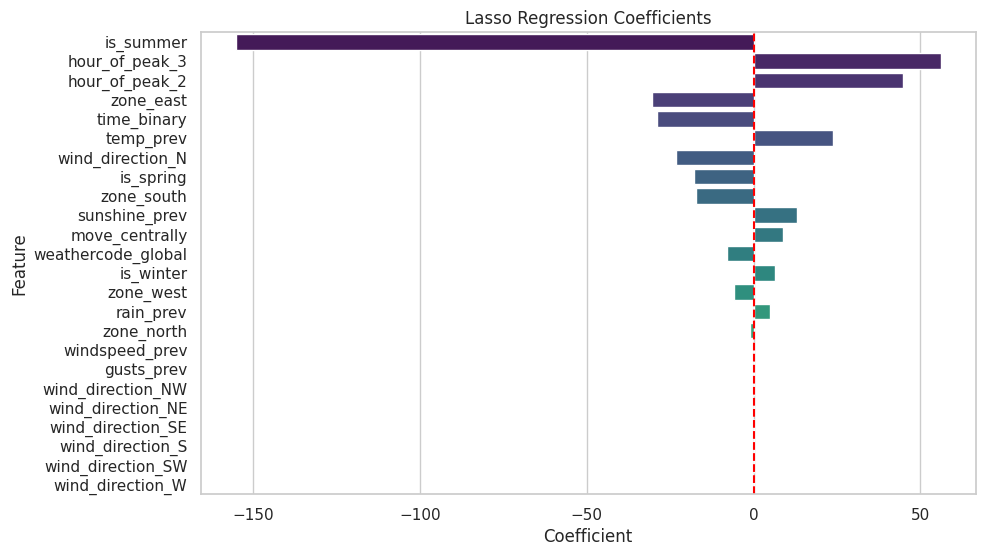

In [ ]:
## Visualise Lasso Regression Feature Coefficients

# Extract feature names
feature_names = (
    numeric_features +
    binary_features +
    list(lasso_pipeline.named_steps["preprocessor"].named_transformers_["cat"]
         .get_feature_names_out(categorical_features)) +
    list(lasso_pipeline.named_steps["preprocessor"].named_transformers_["zone"]
         .named_steps["onehot"].get_feature_names_out(zone_feature))
)

coefficients_lasso = lasso_pipeline.named_steps["regressor"].coef_

coef_df_lasso = pd.DataFrame({
    "Feature": feature_names,
    "Coefficient": coefficients_lasso
}).sort_values(by="Coefficient", key=abs, ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(x="Coefficient", y="Feature", data=coef_df_lasso, palette="viridis")
plt.axvline(0, color="red", linestyle="--")
plt.title("Lasso Regression Coefficients")
plt.savefig("Model2_lasso_regression_coefficients.png", dpi=250, bbox_inches="tight")
plt.show()

## Model 3: Gradient Boosting

#### Gradient Boosting Pipeline and Fit

In [ ]:
gb_pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("regressor", GradientBoostingRegressor(random_state=42))
])

gb_pipeline.fit(X_train, y_train)
y_pred = gb_pipeline.predict(X_test)

rmse_gb = mean_squared_error(y_test, y_pred) ** 0.5 # Corrected RMSE calculation
mae_gb = mean_absolute_error(y_test, y_pred)
r2_gb = r2_score(y_test, y_pred)

print(f"Gradient Boosting")
print(f"RMSE: {rmse_gb:.3f}")
print(f"MAE: {mae_gb:.3f}")
print(f"R²: {r2_gb:.3f}")

Gradient Boosting
RMSE: 179.828
MAE: 129.898
R²: 0.253


**Interpreting the result metrics**
* RMSE = 183.3: this means the typical prediction error is around 183 vehicles
* MAE of 132.98: this means the average absolute difference between predicted and actual traffic count is ~133 vehicles
* R² = 0.22: this means that the Gradient Boosting model only explains 22% of the variance in the traffic count, leaving 78% of the variance unexplained

Overall the Gradient Boosting model performed slightly better than the Ridge Regression model.

### Plot Gradient Boosting Actual vs Predicted Traffic Counts

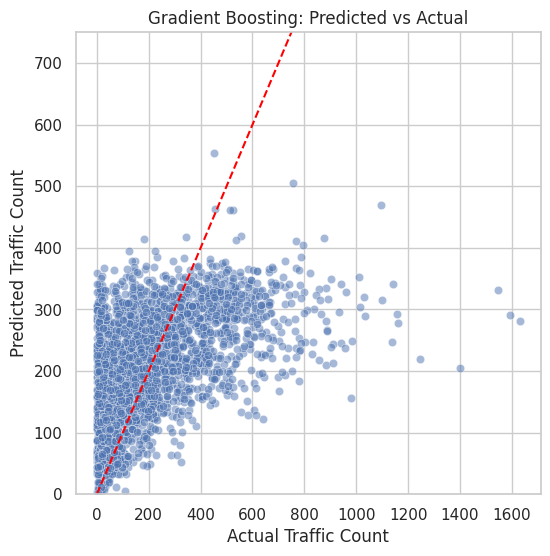

In [ ]:
## Plot predicted vs actual traffic count

plt.figure(figsize=(6,6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()],
         color="red", linestyle="--")
plt.xlabel("Actual Traffic Count")
plt.ylabel("Predicted Traffic Count")
plt.title("Gradient Boosting: Predicted vs Actual")
plt.ylim(0, 750)
plt.savefig("Model2_gradient_boosting_scatter.png", dpi=250, bbox_inches="tight")
plt.show()

** Gradient Boosting plot- actual vs predicted traffic counts, observations:** Similar to the Ridge Regression Actual vs Predicted plot, this plot shows that the Gradient Boosting model is also underfitting, if only mildly less than the Ridge Regression model.

### Plot Gradient Boosting Feature Importances

/tmp/ipython-input-2543198869.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Importance", y="Feature", data=imp_df, palette="viridis")


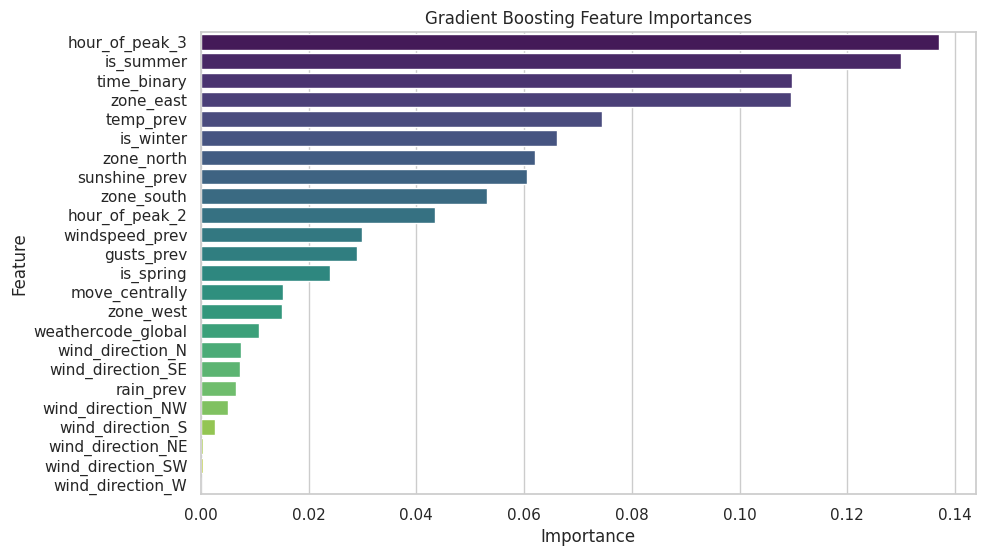

In [ ]:
## Feature Importances

# Extract feature names
feature_names = (
    numeric_features +
    binary_features +
    list(gb_pipeline.named_steps["preprocessor"].named_transformers_["cat"]
         .get_feature_names_out(categorical_features)) +
    list(gb_pipeline.named_steps["preprocessor"].named_transformers_["zone"]
         .named_steps["onehot"].get_feature_names_out(zone_feature))
)

importances = gb_pipeline.named_steps["regressor"].feature_importances_

imp_df = pd.DataFrame({
    "Feature": feature_names,
    "Importance": importances
}).sort_values(by="Importance", ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(x="Importance", y="Feature", data=imp_df, palette="viridis")
plt.title("Gradient Boosting Feature Importances")
plt.savefig("Model2_gradient_boosting_feature_importances.png", dpi=250, bbox_inches="tight")
plt.show()

** Gradient boosting feature importance plot, observations:**
* third hour of peak travel (8-9am, and 6-7pm) was the most important feature - this could reflect overall higher traffic counts during this window: ie, capturing drivers with a shorter commute who leave home later for work, and/or drivers who take leave work just after 5:30pm.
* time of day is an important feature, but this simple binary explains the underlying hour groupings for the AM and PM peak traffic windows.
* zone groups were normalised to handle class imbalance favouring zone=South, and zone_South is the third most important feature for the Gradient Boosting model.

## Model 4: Random Forest Regression

#### Random Forest Regression Pipeline and Fit

In [ ]:
## Random Forest Regression

# Random Forest Regression pipeline
rf_pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("regressor", RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1))
])

# Fit the model
rf_pipeline.fit(X_train, y_train)

# Predictions
y_pred_rf = rf_pipeline.predict(X_test)

# Metrics
rmse_rf = mean_squared_error(y_test, y_pred_rf) ** 0.5
mae_rf = mean_absolute_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

print(f"Random Forest Regression")
print(f"RMSE: {rmse_rf:.3f}")
print(f"MAE: {mae_rf:.3f}")
print(f"R²: {r2_rf:.3f}")

Random Forest Regression
RMSE: 189.082
MAE: 133.452
R²: 0.174


**Interpreting the result metrics for Random Forest Regression:**
* Relative to Ridge Regression, RF Regression performed better on all metrics;
* Relative to GB, RF Regression performed worse on all metrics;

### Plot Random Forest Regression Actual vs Predicted Traffic Counts

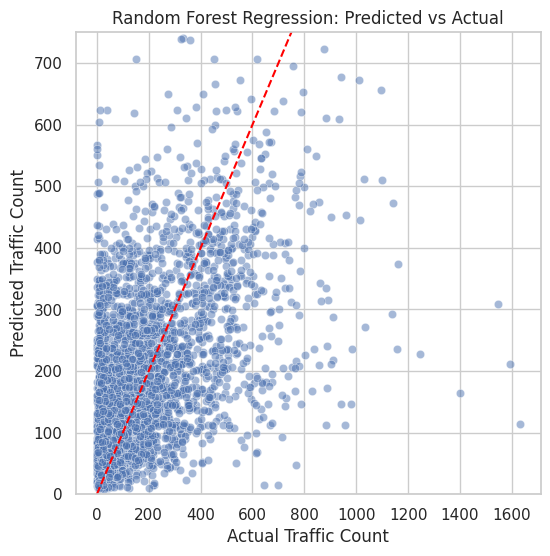

In [ ]:
## Plot predicted vs actual traffic count for Random Forest Regression

plt.figure(figsize=(6,6))
sns.scatterplot(x=y_test, y=y_pred_rf, alpha=0.5)
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()],
         color="red", linestyle="--")
plt.xlabel("Actual Traffic Count")
plt.ylabel("Predicted Traffic Count")
plt.title("Random Forest Regression: Predicted vs Actual")
plt.ylim(0, 750)
plt.savefig("Model2_random_forest_regression_scatter.png", dpi=250, bbox_inches="tight")
plt.show()

**Random Forest Regression plot- actual vs predicted traffic counts, observations:**
* The spread of the predicted values is narrowly clustered toward the y-axis compared with the spread of the actual traffic counts on the x-axis. This suggests that the RF model is struggling to predict the higher traffic counts;
* this model is also underfitting, but relative to Ridge and Lasso regression, this model explains more of the variance in the spread of traffic counts, and we can see that from this plot (plot points are more distributed up and out).

### Plot Random Forest Feature Importances

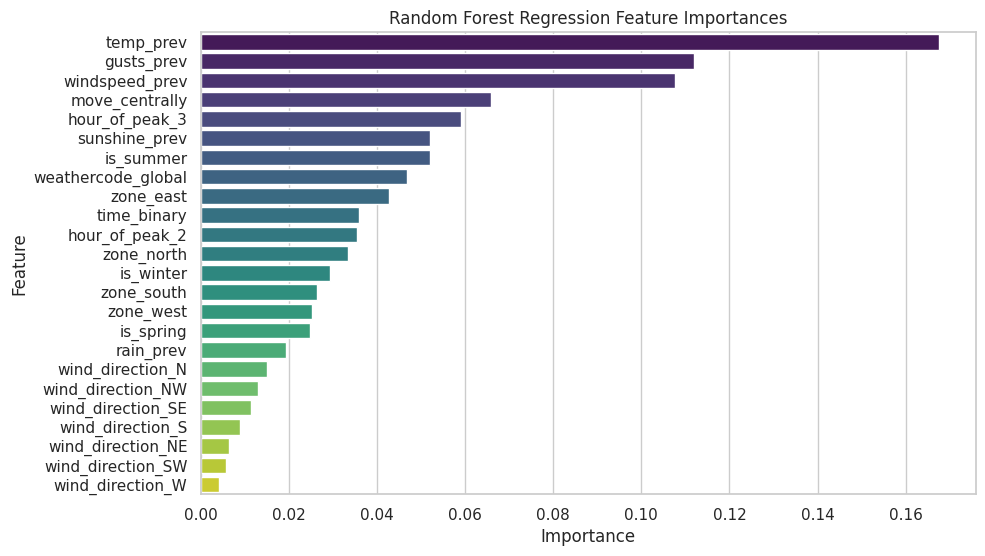

In [ ]:
## Random Forest Feature Importances

# Extract feature names - using the same logic as before
feature_names = (
    numeric_features +
    binary_features +
    list(preprocessor.named_transformers_["cat"]
         .get_feature_names_out(categorical_features)) +
    list(preprocessor.named_transformers_["zone"]
         .named_steps["onehot"].get_feature_names_out(zone_feature))
)

# Get importances from the regressor step in the pipeline
importances_rf = rf_pipeline.named_steps["regressor"].feature_importances_

# Create a DataFrame for visualisation
imp_df_rf = pd.DataFrame({
    "Feature": feature_names,
    "Importance": importances_rf
}).sort_values(by="Importance", ascending=False)

# Plot feature importances
plt.figure(figsize=(10,6))
sns.barplot(x="Importance", y="Feature", data=imp_df_rf, palette="viridis", hue="Feature", legend=False)
plt.title("Random Forest Regression Feature Importances")
plt.savefig("Model3_random_forest_feature_importances.png", dpi=250, bbox_inches="tight")
plt.show()

**Random Forest Feature Importance plot, observations:**

*The top 5 features:*
* `temp_prev`, `windspeed_prev`, `gusts_prev` as highly important features emphasises the role of previous weather in predicting traffic count
* `hour_of_peak_3` and `move_centrally` end up representative of both morning and evening commuting windows, i.e. move_centrally=1 was applied to traffic movement oriented toward Central Wellington and with this model may be the strongest predictor of morning peak traffic counts. hour_of_peak_3 covers both the 8am-9am morning commute window and the 6pm-7pm evening commute window.

Overally, the Random Forest feature importance is more consistent with EDA observations for this data, and with feature importances for the Gradient Boosting model.

## Model 5: Random Forest Regression with HalvingRandomCV Hyperparameter Tuning

In [ ]:
## Random Forest Regression with Hyperparameter Tuning using HalvingRandomSearchCV

# Define the parameter grid to search

# A reduced grid for a quick initial test
param_grid = {
    #'regressor__n_estimators': [100, 300, 500, 800],    # Number of trees in forest
    'regressor__max_depth': [5, 10, 20, 30, None],      # Max depth of the trees
    'regressor__min_samples_split': [2, 5, 10, 15],         # Min no. samples required to split an internal node
    'regressor__min_samples_leaf': [1, 2, 4, 8],         # Min no. samples required to be at a leaf node
    'regressor__max_features': ['auto', 'sqrt', 'log2', 0.5],    # Max no. features to consider when looking for the best split
    'regressor__bootstrap': [True, False],                       # Whether bootstrap samples are used when building trees
    'regressor__criterion': ['squared_error','absolute_error'] # measure the quality of a split
}

halving_search = HalvingRandomSearchCV(
    estimator=rf_pipeline,
    param_distributions=param_grid,
    factor=2,                        # eliminates options slightly more slowly, by keeping 50% at a time
    n_candidates=100,
    resource="regressor__n_estimators", # resource to allocate progressively
    max_resources=1000,
    cv=5,
    verbose=1,
    n_jobs=-1,
    scoring='neg_root_mean_squared_error',
    random_state=42
)

In [ ]:
# Fit the randomized search to the training data
halving_search.fit(X_train, y_train)

print("Best parameters:", halving_search.best_params_)
print("Best CV score:", halving_search.best_score_)

n_iterations: 7
n_required_iterations: 7
n_possible_iterations: 10
min_resources_: 1
max_resources_: 1000
aggressive_elimination: False
factor: 2
----------
iter: 0
n_candidates: 100
n_resources: 1
Fitting 5 folds for each of 100 candidates, totalling 500 fits


/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
120 fits failed out of a total of 500.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
120 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.12/dist-packages/sklearn/base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/sklearn/pipeline.py", line 662, in fit
    self._final_estimator.fit(Xt, y, *

----------
iter: 1
n_candidates: 50
n_resources: 2
Fitting 5 folds for each of 50 candidates, totalling 250 fits


/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_search.py:1108: UserWarning: One or more of the test scores are non-finite: [-205.94688175 -192.52144079           nan           nan -194.20688487
 -208.40840182 -201.35229507 -237.0417153  -208.8593732  -207.74896002
           nan -206.95915013           nan -198.60907647           nan
           nan           nan -207.71022711 -218.90665633 -202.09512079
 -202.87062058           nan -207.72169204           nan           nan
 -204.29924658           nan -207.81859094           nan -208.45408808
 -209.55489388 -207.59480066           nan           nan -196.96594324
 -199.84680219 -194.22404205 -230.45024804 -205.94688175 -199.33135411
 -201.81141437 -204.18452264 -201.35229507 -200.0488129  -207.57817226
 -199.21001931 -207.58554445 -199.78710507 -205.37486172           nan
           nan -207.84971003 -201.59300328 -194.29067261 -194.57893428
 -204.29924658           nan -207.39202087 -218.45374336           nan
 -189.0

----------
iter: 2
n_candidates: 25
n_resources: 4
Fitting 5 folds for each of 25 candidates, totalling 125 fits


/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_search.py:1108: UserWarning: One or more of the test scores are non-finite: [-205.94688175 -192.52144079           nan           nan -194.20688487
 -208.40840182 -201.35229507 -237.0417153  -208.8593732  -207.74896002
           nan -206.95915013           nan -198.60907647           nan
           nan           nan -207.71022711 -218.90665633 -202.09512079
 -202.87062058           nan -207.72169204           nan           nan
 -204.29924658           nan -207.81859094           nan -208.45408808
 -209.55489388 -207.59480066           nan           nan -196.96594324
 -199.84680219 -194.22404205 -230.45024804 -205.94688175 -199.33135411
 -201.81141437 -204.18452264 -201.35229507 -200.0488129  -207.57817226
 -199.21001931 -207.58554445 -199.78710507 -205.37486172           nan
           nan -207.84971003 -201.59300328 -194.29067261 -194.57893428
 -204.29924658           nan -207.39202087 -218.45374336           nan
 -189.0

----------
iter: 3
n_candidates: 13
n_resources: 8
Fitting 5 folds for each of 13 candidates, totalling 65 fits


/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_search.py:1108: UserWarning: One or more of the test scores are non-finite: [-205.94688175 -192.52144079           nan           nan -194.20688487
 -208.40840182 -201.35229507 -237.0417153  -208.8593732  -207.74896002
           nan -206.95915013           nan -198.60907647           nan
           nan           nan -207.71022711 -218.90665633 -202.09512079
 -202.87062058           nan -207.72169204           nan           nan
 -204.29924658           nan -207.81859094           nan -208.45408808
 -209.55489388 -207.59480066           nan           nan -196.96594324
 -199.84680219 -194.22404205 -230.45024804 -205.94688175 -199.33135411
 -201.81141437 -204.18452264 -201.35229507 -200.0488129  -207.57817226
 -199.21001931 -207.58554445 -199.78710507 -205.37486172           nan
           nan -207.84971003 -201.59300328 -194.29067261 -194.57893428
 -204.29924658           nan -207.39202087 -218.45374336           nan
 -189.0

----------
iter: 4
n_candidates: 7
n_resources: 16
Fitting 5 folds for each of 7 candidates, totalling 35 fits


/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_search.py:1108: UserWarning: One or more of the test scores are non-finite: [-205.94688175 -192.52144079           nan           nan -194.20688487
 -208.40840182 -201.35229507 -237.0417153  -208.8593732  -207.74896002
           nan -206.95915013           nan -198.60907647           nan
           nan           nan -207.71022711 -218.90665633 -202.09512079
 -202.87062058           nan -207.72169204           nan           nan
 -204.29924658           nan -207.81859094           nan -208.45408808
 -209.55489388 -207.59480066           nan           nan -196.96594324
 -199.84680219 -194.22404205 -230.45024804 -205.94688175 -199.33135411
 -201.81141437 -204.18452264 -201.35229507 -200.0488129  -207.57817226
 -199.21001931 -207.58554445 -199.78710507 -205.37486172           nan
           nan -207.84971003 -201.59300328 -194.29067261 -194.57893428
 -204.29924658           nan -207.39202087 -218.45374336           nan
 -189.0

----------
iter: 5
n_candidates: 4
n_resources: 32
Fitting 5 folds for each of 4 candidates, totalling 20 fits


/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_search.py:1108: UserWarning: One or more of the test scores are non-finite: [-205.94688175 -192.52144079           nan           nan -194.20688487
 -208.40840182 -201.35229507 -237.0417153  -208.8593732  -207.74896002
           nan -206.95915013           nan -198.60907647           nan
           nan           nan -207.71022711 -218.90665633 -202.09512079
 -202.87062058           nan -207.72169204           nan           nan
 -204.29924658           nan -207.81859094           nan -208.45408808
 -209.55489388 -207.59480066           nan           nan -196.96594324
 -199.84680219 -194.22404205 -230.45024804 -205.94688175 -199.33135411
 -201.81141437 -204.18452264 -201.35229507 -200.0488129  -207.57817226
 -199.21001931 -207.58554445 -199.78710507 -205.37486172           nan
           nan -207.84971003 -201.59300328 -194.29067261 -194.57893428
 -204.29924658           nan -207.39202087 -218.45374336           nan
 -189.0

----------
iter: 6
n_candidates: 2
n_resources: 64
Fitting 5 folds for each of 2 candidates, totalling 10 fits


/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_search.py:1108: UserWarning: One or more of the test scores are non-finite: [-205.94688175 -192.52144079           nan           nan -194.20688487
 -208.40840182 -201.35229507 -237.0417153  -208.8593732  -207.74896002
           nan -206.95915013           nan -198.60907647           nan
           nan           nan -207.71022711 -218.90665633 -202.09512079
 -202.87062058           nan -207.72169204           nan           nan
 -204.29924658           nan -207.81859094           nan -208.45408808
 -209.55489388 -207.59480066           nan           nan -196.96594324
 -199.84680219 -194.22404205 -230.45024804 -205.94688175 -199.33135411
 -201.81141437 -204.18452264 -201.35229507 -200.0488129  -207.57817226
 -199.21001931 -207.58554445 -199.78710507 -205.37486172           nan
           nan -207.84971003 -201.59300328 -194.29067261 -194.57893428
 -204.29924658           nan -207.39202087 -218.45374336           nan
 -189.0

Best parameters: {'regressor__min_samples_split': 10, 'regressor__min_samples_leaf': 1, 'regressor__max_features': 0.5, 'regressor__max_depth': 10, 'regressor__criterion': 'squared_error', 'regressor__bootstrap': False, 'regressor__n_estimators': 64}
Best CV score: -179.62562971669917


In [ ]:
## Isolate best RF model from grid search, get results

# Get the best model from the grid search
#best_rf_model = grid_search_rf.best_estimator_
best_rf_model = halving_search.best_estimator_

# Make predictions on the test set using the best model
y_pred_best_rf = best_rf_model.predict(X_test)

# Evaluate the best model
rmse_best_rf = mean_squared_error(y_test, y_pred_best_rf) ** 0.5
mae_best_rf = mean_absolute_error(y_test, y_pred_best_rf)
r2_best_rf = r2_score(y_test, y_pred_best_rf)


print(f"Random Forest Regression (Tuned - RandomHalving)")
print(f"RMSE: {rmse_best_rf:.2f}")
print(f"MAE: {mae_best_rf:.2f}")
print(f"R²: {r2_best_rf:.3f}")

Random Forest Regression (Tuned - RandomHalving)
RMSE: 176.05
MAE: 126.99
R²: 0.284




Best parameters using factor=2, + not setting n_estimators range in param_grid:
{'regressor__min_samples_split': 10,
 'regressor__min_samples_leaf': 1,
 'regressor__max_features': 0.5,
 'regressor__max_depth': 10,
 'regressor__criterion': 'squared_error',
 'regressor__bootstrap': True,
 'regressor__n_estimators': 64}
Best CV score: -182.28924862422042
Random Forest Regression (Tuned - RandomHalving)
RMSE: 179.41
MAE: 129.20
R²: 0.256


## Model 6: Neural Network - MLP Regressor

### MLP Regressor HalvingRandomSearchCV pipeline and Fit

In [ ]:
## MLPRegressor

# pipeline with preprocessor + MLP
mlp_pipeline = Pipeline([
    ("preprocessor", preprocessor),   # Use the defined preprocessor
    ("mlp", MLPRegressor(
        hidden_layer_sizes=(64, 32),  # two hidden layers
        activation="relu",
        solver="adam",
        alpha=1e-4,                   # L2 regularization
        learning_rate="adaptive",
        max_iter=500,
        random_state=42,
        early_stopping=True,          # helps prevent overfitting
        n_iter_no_change=10
    ))
])

# Fit and evaluate
mlp_pipeline.fit(X_train, y_train)
y_pred = mlp_pipeline.predict(X_test)

MLP_RMSE = mean_squared_error(y_test, y_pred) ** 0.5
MLP_MAE = mean_absolute_error(y_test, y_pred)
MLP_R2 = r2_score(y_test, y_pred)

print("MLP RMSE:", MLP_RMSE)
print("MLP MAE:", MLP_MAE)
print("MLP R²:", MLP_R2)

MLP RMSE: 177.92171443406383
MLP MAE: 127.64332665028597
MLP R²: 0.268386707354377


## Model 7: MLP Regressor with HalvingRandomCV Hyperparameter Tuning

### Define hyperparameter grid for MLP Regressor

In [ ]:
param_grid_mlp = {
    'mlp__hidden_layer_sizes': [(64, 32), (128, 64, 32), (100,), (50, 25)],
    'mlp__activation': ['relu', 'tanh'],
    'mlp__solver': ['adam', 'sgd'],
    'mlp__alpha': [0.0001, 0.001, 0.01],
    'mlp__learning_rate': ['constant', 'adaptive']
}

halving_search_mlp = HalvingRandomSearchCV(
    estimator=mlp_pipeline,
    param_distributions=param_grid_mlp,
    factor=2,
    resource='mlp__max_iter',
    max_resources=1200,
    cv=5,
    verbose=1,
    n_jobs=-1,
    scoring='neg_root_mean_squared_error',
    random_state=42
)

In [ ]:
halving_search_mlp.fit(X_train, y_train)

n_iterations: 7
n_required_iterations: 7
n_possible_iterations: 11
min_resources_: 1
max_resources_: 1200
aggressive_elimination: False
factor: 2
----------
iter: 0
n_candidates: 96
n_resources: 1
Fitting 5 folds for each of 96 candidates, totalling 480 fits


/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 96 is smaller than n_iter=1200. Running 96 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


----------
iter: 1
n_candidates: 48
n_resources: 2
Fitting 5 folds for each of 48 candidates, totalling 240 fits
----------
iter: 2
n_candidates: 24
n_resources: 4
Fitting 5 folds for each of 24 candidates, totalling 120 fits
----------
iter: 3
n_candidates: 12
n_resources: 8
Fitting 5 folds for each of 12 candidates, totalling 60 fits
----------
iter: 4
n_candidates: 6
n_resources: 16
Fitting 5 folds for each of 6 candidates, totalling 30 fits
----------
iter: 5
n_candidates: 3
n_resources: 32
Fitting 5 folds for each of 3 candidates, totalling 15 fits
----------
iter: 6
n_candidates: 2
n_resources: 64
Fitting 5 folds for each of 2 candidates, totalling 10 fits


/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (64) reached and the optimization hasn't converged yet.
  warnings.warn(


HalvingRandomSearchCV(estimator=Pipeline(steps=[('preprocessor',
                                                 ColumnTransformer(transformers=[('num',
                                                                                  StandardScaler(),
                                                                                  ['gusts_prev',
                                                                                   'rain_prev',
                                                                                   'sunshine_prev',
                                                                                   'temp_prev',
                                                                                   'windspeed_prev',
                                                                                   'weathercode_global']),
                                                                                 ('bin',
                                                                                  'passthrough',
                                                                                  ['time_binary',
                                                                                   'move_centrally',
                                                                                   'is_spring',
                                                                                   'is_summer',
                                                                                   'is_winter']),
                                                                                 ('cat',
                                                                                  OneHotEncoder(drop='first',
                                                                                                sparse_outp...
                      factor=2, max_resources=1200, n_jobs=-1,
                      param_distributions={'mlp__activation': ['relu', 'tanh'],
                                           'mlp__alpha': [0.0001, 0.001, 0.01],
                                           'mlp__hidden_layer_sizes': [(64, 32),
                                                                       (128, 64,
                                                                        32),
                                                                       (100,),
                                                                       (50,
                                                                        25)],
                                           'mlp__learning_rate': ['constant',
                                                                  'adaptive'],
                                           'mlp__solver': ['adam', 'sgd']},
                      random_state=42, resource='mlp__max_iter',
                      scoring='neg_root_mean_squared_error', verbose=1)

### Evaluate the best model for MLP with HalvingRandomSearchCV


In [ ]:
# Get the best model from the halving search
best_mlp_model = halving_search_mlp.best_estimator_

# Make predictions on the test set using the best model
y_pred_tuned_mlp = best_mlp_model.predict(X_test)

# Evaluate the best model
rmse_tuned_mlp = mean_squared_error(y_test, y_pred_tuned_mlp) ** 0.5
mae_tuned_mlp = mean_absolute_error(y_test, y_pred_tuned_mlp)
r2_tuned_mlp = r2_score(y_test, y_pred_tuned_mlp)

# Print the results
print("MLP Regressor (Tuned - HalvingRandomSearch)")
print(f"RMSE: {rmse_tuned_mlp:.2f}")
print(f"MAE: {mae_tuned_mlp:.2f}")
print(f"R²: {r2_tuned_mlp:.3f}")

MLP Regressor (Tuned - HalvingRandomSearch)
RMSE: 177.33
MAE: 127.10
R²: 0.273


In [ ]:
print("Best parameters:", halving_search_mlp.best_params_)
print("Best CV score:", halving_search_mlp.best_score_)

Best parameters: {'mlp__solver': 'sgd', 'mlp__learning_rate': 'adaptive', 'mlp__hidden_layer_sizes': (100,), 'mlp__alpha': 0.0001, 'mlp__activation': 'relu', 'mlp__max_iter': 64}
Best CV score: -180.30070022423752


## Comparison DataFrame of results for each model



In [ ]:
# Create a DataFrame to store model performance
performance_df = pd.DataFrame({
    "Model": ["Ridge Regression", "Lasso Regression", "Gradient Boosting", "Random Forest",
              "Tuned Random Forest", "MLP Regressor", "Tuned MLP Regressor"],
    "RMSE": [rmse_rr, rmse_lr, rmse_gb, rmse_rf, rmse_best_rf, MLP_RMSE, rmse_tuned_mlp],
    "MAE": [mae_rr, mae_lr, mae_gb, mae_rf, mae_best_rf, MLP_MAE, mae_tuned_mlp],
    "R²": [r2_rr, r2_lr, r2_gb, r2_rf, r2_best_rf, MLP_R2, r2_tuned_mlp]
})

# Display the performance comparison
display(performance_df)

,Model,RMSE,MAE,R²
0,Ridge Regression,192.806056,143.254279,0.140858
1,Lasso Regression,192.864353,143.276556,0.140338
2,Gradient Boosting,179.828229,129.898482,0.252624
3,Random Forest,189.082394,133.451542,0.173723
4,Tuned Random Forest,176.051375,126.990316,0.283688
5,MLP Regressor,177.921714,127.643327,0.268387
6,Tuned MLP Regressor,177.334299,127.100007,0.273210


Comparing the performance of each model, Random Forest with hyperparameter tuning performed best with an R² of 27%, and the lowest number of vehicles missed by the model (118).




## Visualise Comparison Feature Importances across Ridge Regression, Lasso Regression, Gradient Boosting, Random Forest, and MLP models

### Plot comparing top features across Ridge, Lasso, Gradient Boosting, Random Forest, and MLP

### Extract feature importances for each model:

* absolute coefficients for Ridge and Lasso Regression,
* tree-based importance for Gradient Boosting and Random Forest, and
* permutation importance for MLP


In [ ]:
# 1. Extract absolute coefficients for Ridge
ridge_coef = np.abs(ridge_pipeline.named_steps["regressor"].coef_)

# 2. Extract absolute coefficients for Lasso
lasso_coef = np.abs(lasso_pipeline.named_steps["regressor"].coef_)

# 3. Extract feature importances for Gradient Boosting
gb_importance = gb_pipeline.named_steps["regressor"].feature_importances_

# 4. Extract feature importances for Random Forest
rf_importance = rf_pipeline.named_steps["regressor"].feature_importances_

# 5. Extract feature importances for Tuned Random Forest
rf_importance_best = best_rf_model.named_steps["regressor"].feature_importances_

# Apply the preprocessor to the test data for MLP permutation importance
X_test_processed = preprocessor.transform(X_test)

# 6. Extract mean permutation importances for MLP (using preprocessed data)
# Pass the regressor step of the pipeline, not the whole pipeline
result_mlp = permutation_importance(
    mlp_pipeline.named_steps["mlp"], # Pass the MLP regressor
    X_test_processed,                # Pass the preprocessed test data
    y_test,
    n_repeats=10,
    random_state=42,
    n_jobs=-1 # Use all available cores
)
mlp_importance = result_mlp.importances_mean

# 7. Extract mean permutation importances for Tuned MLP (using preprocessed data)
# Pass the regressor step of the pipeline, not the whole pipeline
result_halving_mlp = permutation_importance(
    best_mlp_model.named_steps["mlp"], # Pass the tuned MLP regressor
    X_test_processed,                  # Pass the preprocessed test data
    y_test,
    n_repeats=10,
    random_state=42,
    n_jobs=-1 # Use all available cores
)
mlp_importance_best = result_halving_mlp.importances_mean

In [ ]:
# Extract feature names - using the same logic as before
feature_names = (
    numeric_features +
    binary_features +
    list(preprocessor.named_transformers_["cat"]
         .get_feature_names_out(categorical_features)) +
    list(preprocessor.named_transformers_["zone"]
         .named_steps["onehot"].get_feature_names_out(zone_feature))
)


# 3. Combine Importances

# Create DataFrames for each model's importances
ridge_imp_df = pd.DataFrame({
    "Feature": feature_names,
    "Importance": ridge_coef,
    "Model": "Ridge"
})

lasso_imp_df = pd.DataFrame({
    "Feature": feature_names,
    "Importance": lasso_coef,
    "Model": "Lasso"
})

gb_imp_df = pd.DataFrame({
    "Feature": feature_names,
    "Importance": gb_importance,
    "Model": "Gradient Boosting"
})

rf_imp_df = pd.DataFrame({
    "Feature": feature_names,
    "Importance": rf_importance,
    "Model": "Random Forest"
})

rf_tuned_imp_df = pd.DataFrame({
    "Feature": feature_names,
    "Importance": rf_importance_best,
    "Model": "Tuned Random Forest"
})

mlp_imp_df = pd.DataFrame({
    "Feature": feature_names,
    "Importance": mlp_importance,
    "Model": "MLP"
})

mlp_tuned_imp_df = pd.DataFrame({
    "Feature": feature_names,
    "Importance": mlp_importance_best,
    "Model": "Tuned MLP"
})


# Concatenate all DataFrames
all_importances = pd.concat([
    ridge_imp_df,
    lasso_imp_df,
    gb_imp_df,
    rf_imp_df,
    rf_tuned_imp_df,
    mlp_imp_df,
    mlp_tuned_imp_df
])

display(all_importances.head())

,Feature,Importance,Model
0,gusts_prev,13.996948,Ridge
1,rain_prev,6.948850,Ridge
2,sunshine_prev,10.614269,Ridge
3,temp_prev,34.082767,Ridge
4,windspeed_prev,12.494041,Ridge


In [ ]:
# Check the number of features per model
feature_counts_per_model = all_importances.groupby("Model")["Feature"].nunique()
print("Number of features per model:")
print(feature_counts_per_model)

Number of features per model:
Model
Gradient Boosting      24
Lasso                  24
MLP                    24
Random Forest          24
Ridge                  24
Tuned MLP              24
Tuned Random Forest    24
Name: Feature, dtype: int64


### Select the top 10 features per model


In [ ]:
## Select the top 10 features per model, for plotting

# Get the original coefficients for Ridge and Lasso
ridge_original_coef = ridge_pipeline.named_steps["regressor"].coef_
lasso_original_coef = lasso_pipeline.named_steps["regressor"].coef_

# Create DataFrames for original coefficients with feature names
ridge_original_coef_df = pd.DataFrame({
    "Feature": feature_names,
    "Original_Coefficient": ridge_original_coef
})

lasso_original_coef_df = pd.DataFrame({
    "Feature": feature_names,
    "Original_Coefficient": lasso_original_coef
})

top_features_per_model = all_importances.groupby("Model").apply(
    lambda x: x.sort_values(by="Importance", ascending=False).head(10)
).reset_index(drop=True)

# Relabel features with negative original coefficients for Ridge and Lasso
for model_name, original_coef_df in [("Ridge", ridge_original_coef_df), ("Lasso", lasso_original_coef_df)]:
    # Get the top features for the current model from top_features_per_model
    top_features_current_model = top_features_per_model[top_features_per_model["Model"] == model_name].copy()

    # Merge with original coefficients to get the sign
    merged_df = top_features_current_model.merge(original_coef_df, on="Feature", how="left")

    # Identify features with negative original coefficients
    negative_features = merged_df[merged_df["Original_Coefficient"] < 0]["Feature"].tolist()

    # Relabel the features in top_features_per_model
    top_features_per_model.loc[
        (top_features_per_model["Model"] == model_name) &
        (top_features_per_model["Feature"].isin(negative_features)),
        "Feature"
    ] = top_features_per_model.loc[
        (top_features_per_model["Model"] == model_name) &
        (top_features_per_model["Feature"].isin(negative_features)),
        "Feature"
    ] + " (-)"

display(top_features_per_model)

/tmp/ipython-input-1635499247.py:18: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  top_features_per_model = all_importances.groupby("Model").apply(


,Feature,Importance,Model
0,hour_of_peak_3,0.136985,Gradient Boosting
1,is_summer,0.129964,Gradient Boosting
2,time_binary,0.109670,Gradient Boosting
3,zone_east,0.109474,Gradient Boosting
4,temp_prev,0.074500,Gradient Boosting
...,...,...,...
65,sunshine_prev,0.066839,Tuned Random Forest
66,hour_of_peak_2,0.063317,Tuned Random Forest
67,gusts_prev,0.060181,Tuned Random Forest
68,windspeed_prev,0.054462,Tuned Random Forest


### Combine top features per model for plotting

In [ ]:
# Verify the number of features per model in the new DataFrame
feature_counts_top10 = top_features_per_model.groupby("Model")["Feature"].nunique()
print("Number of top 10 features per model:")
print(feature_counts_top10)

# Confirm the columns in the DataFrame
print("\nColumns in top_features_per_model DataFrame:")
print(top_features_per_model.columns)

# Display the first few rows to visually inspect
print("\nFirst 5 rows of top_features_per_model:")
display(top_features_per_model.head())

Number of top 10 features per model:
Model
Gradient Boosting      10
Lasso                  10
MLP                    10
Random Forest          10
Ridge                  10
Tuned MLP              10
Tuned Random Forest    10
Name: Feature, dtype: int64

Columns in top_features_per_model DataFrame:
Index(['Feature', 'Importance', 'Model'], dtype='object')

First 5 rows of top_features_per_model:


,Feature,Importance,Model
0,hour_of_peak_3,0.136985,Gradient Boosting
1,is_summer,0.129964,Gradient Boosting
2,time_binary,0.109670,Gradient Boosting
3,zone_east,0.109474,Gradient Boosting
4,temp_prev,0.074500,Gradient Boosting


### Visualize comparison

/tmp/ipython-input-2320905591.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Importance", y="Feature", data=data_sorted, palette="viridis", ax=plt.gca())
/tmp/ipython-input-2320905591.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Importance", y="Feature", data=data_sorted, palette="viridis", ax=plt.gca())
/tmp/ipython-input-2320905591.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Importance", y="Feature", data=data_sorted, palette="viridis", ax=plt.gca())
/tmp/ipython-input-2320905591.py:8: FutureWarning: 

Passing 

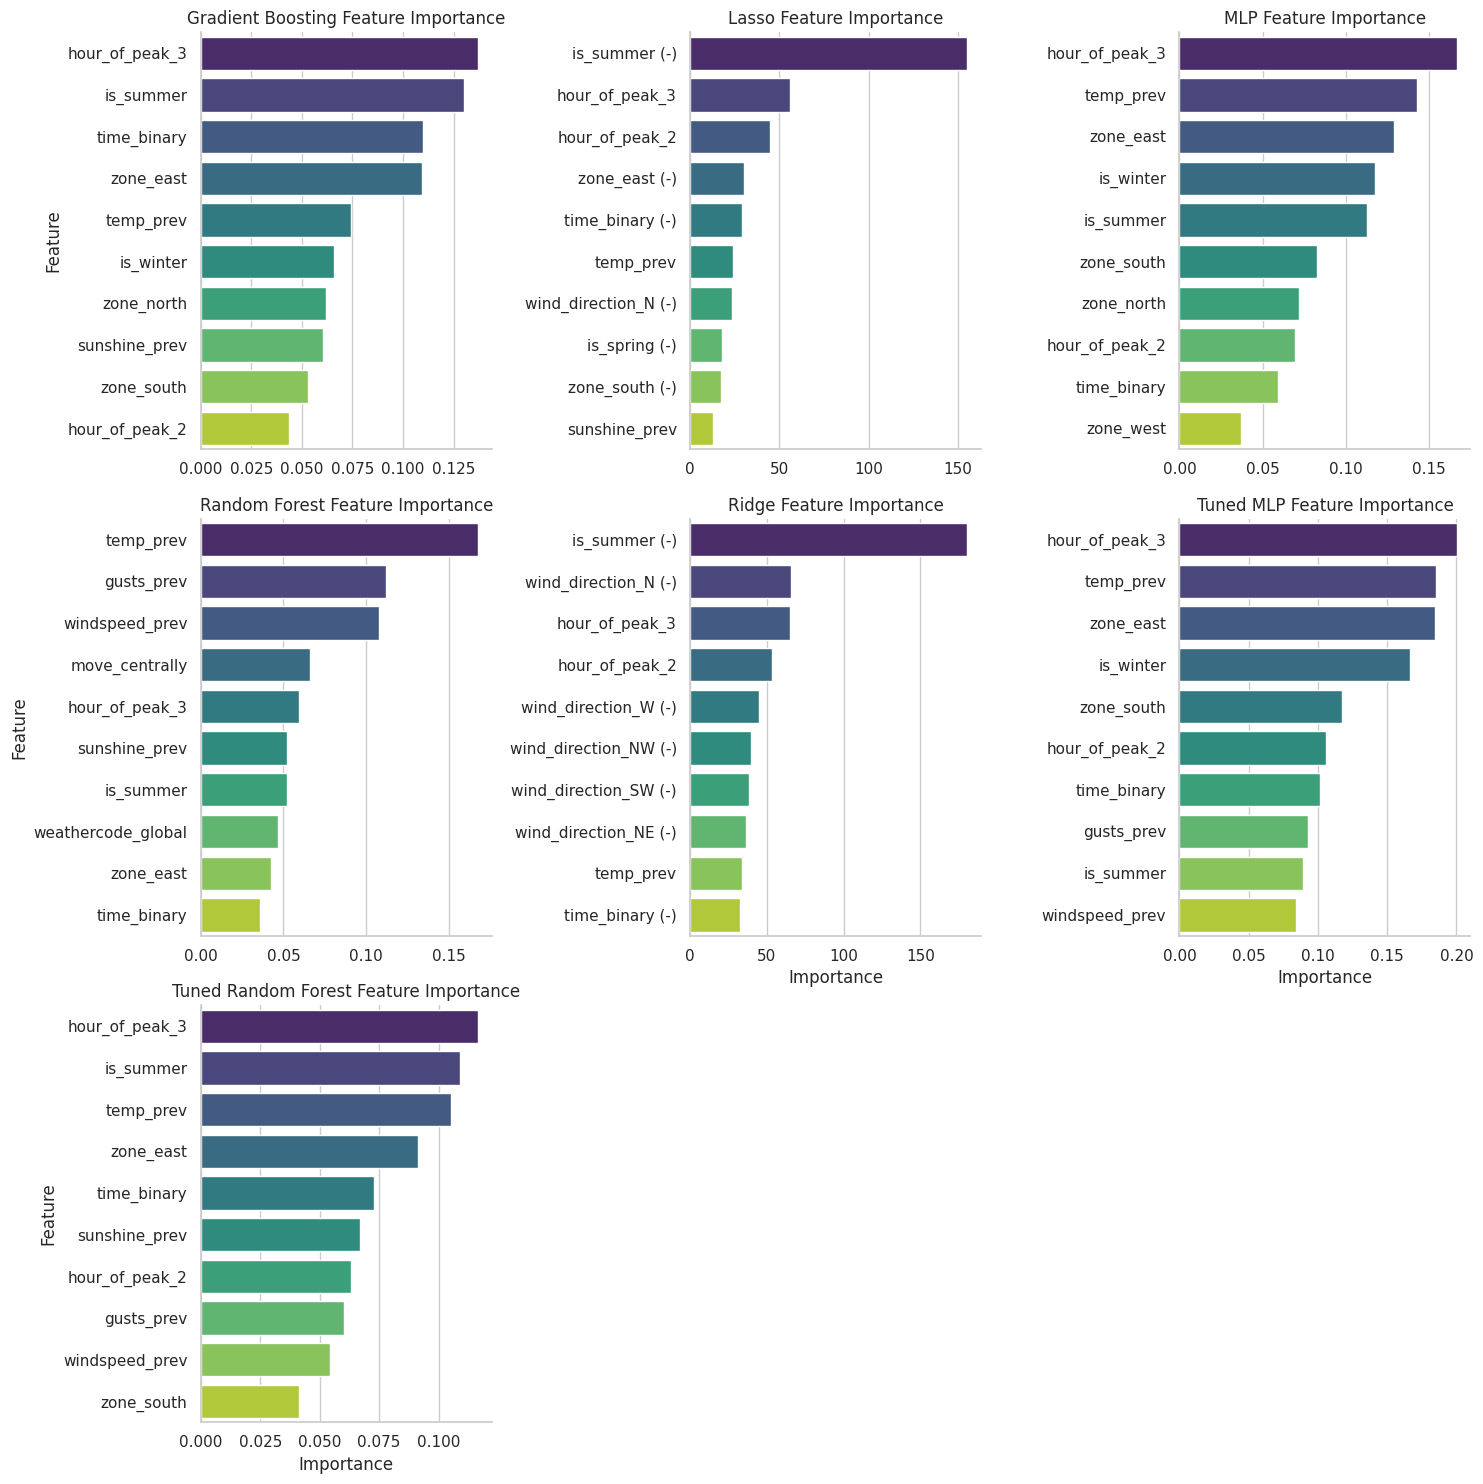

In [ ]:
## Define a helper function to plot the top 10 features with the greatest effect on traffic counts, per model

def plot_feature_importance(data, color):
    """Helper function to plot feature importance for each model."""
    # Sort the data by importance in descending order within each facet
    data_sorted = data.sort_values(by="Importance", ascending=False)
    # Create the bar plot for the sorted data
    sns.barplot(x="Importance", y="Feature", data=data_sorted, palette="viridis", ax=plt.gca())
    # Optional: Adjust x-axis limits for better visualization within each facet
    # plt.xlim(0, data_sorted["Importance"].max() * 1.1)


# Create a FacetGrid
g = sns.FacetGrid(top_features_per_model, col="Model", col_wrap=3, height=5, sharey=False, sharex=False) # Ensure independent x and y axes

# Map the plotting function to the FacetGrid
g.map_dataframe(plot_feature_importance)

# Set titles and labels
g.set_titles("{col_name} Feature Importance")
g.set_axis_labels("Importance", "Feature")

# Adjust layout and save/show the plot
plt.tight_layout()
plt.savefig("top10_feature_importances_comparison.png", dpi=250, bbox_inches="tight")
plt.show()

In [ ]:
print("Unique models in top_features_per_model:")
print(top_features_per_model["Model"].unique())

print("\nFirst 15 rows of top_features_per_model:")
display(top_features_per_model.head(15))

# Also, let's check the descriptive statistics of the importance scores per model
print("\nImportance statistics per model in top_features_per_model:")
display(top_features_per_model.groupby("Model")["Importance"].describe())

Unique models in top_features_per_model:
['Gradient Boosting' 'Lasso' 'MLP' 'Random Forest' 'Ridge' 'Tuned MLP'
 'Tuned Random Forest']

First 15 rows of top_features_per_model:


,Feature,Importance,Model
0,hour_of_peak_3,0.136985,Gradient Boosting
1,is_summer,0.129964,Gradient Boosting
2,time_binary,0.109670,Gradient Boosting
3,zone_east,0.109474,Gradient Boosting
4,temp_prev,0.074500,Gradient Boosting
5,is_winter,0.066051,Gradient Boosting
6,zone_north,0.061970,Gradient Boosting
7,sunshine_prev,0.060543,Gradient Boosting
8,zone_south,0.053161,Gradient Boosting
9,hour_of_peak_2,0.043500,Gradient Boosting



Importance statistics per model in top_features_per_model:


,count,mean,std,min,25%,50%,75%,max
Model,,,,,,,,
Gradient Boosting,10.0,0.084582,0.033770,0.043500,0.060900,0.070275,0.109621,0.136985
Lasso,10.0,41.071891,42.220549,12.937374,19.271574,26.465608,41.176651,155.239009
MLP,10.0,0.098855,0.041197,0.036958,0.069990,0.097535,0.126028,0.166658
Random Forest,10.0,0.074174,0.041822,0.035894,0.048182,0.055644,0.097202,0.167529
Ridge,10.0,59.228173,44.337576,32.566008,37.147218,42.472794,62.415534,180.563085
Tuned MLP,10.0,0.132730,0.045818,0.084354,0.095052,0.111550,0.179900,0.200108
Tuned Random Forest,10.0,0.078075,0.025712,0.041170,0.060965,0.069855,0.101746,0.116484


In [ ]:
# dummy encoded (masked) binary features

# Access the fitted one-hot encoder for categorical features
categorical_onehot = preprocessor.named_transformers_['cat']
wind_direction_categories = categorical_onehot.categories_[0]
hour_of_peak_categories = categorical_onehot.categories_[1]

# Access the fitted one-hot encoder for the zone feature within the pipeline
zone_onehot = preprocessor.named_transformers_['zone'].named_steps['onehot']
zone_categories = zone_onehot.categories_[0]

# Identify the dropped category for each feature
dropped_wind_direction = wind_direction_categories[0]
dropped_hour_of_peak = hour_of_peak_categories[0]
dropped_zone = zone_categories[0]

print(f"Dropped dummy variable for wind_direction: {dropped_wind_direction}")
print(f"Dropped dummy variable for hour_of_peak: {dropped_hour_of_peak}")
print(f"Dropped dummy variable for zone: {dropped_zone}")

Dropped dummy variable for wind_direction: E
Dropped dummy variable for hour_of_peak: 1
Dropped dummy variable for zone: central
